# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**1.1 Импортируем необходимые библиотеки.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


RANDOM_STATE=12345

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install missingno

import missingno as msno

**1.2 Пользовательские функции.**

Напишем функцию для первичной проверки данных:

In [3]:
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных:

In [4]:
def plot_hist(data, col_column):
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

**1.3 Загрузим данные.**

In [5]:
df = pd.read_csv('/datasets/autos.csv')

In [6]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


**1.4 Первичный осмотр данных.**

Описательный анализ:

In [7]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Посмотрим дату создания последней анкеты:

In [8]:
df.DateCreated.max()

'2016-04-07 00:00:00'

Вывод:
- в нашей таблице 16 столбцов и 354368 строк;
- 30% строк содержит пропуски;
- выявлены дубликаты;
- название столбцов в "верблюжьем стиле";
- есть аномальные значения.

**Проведём предобработку данных:**

Вывод всех задублированных строк:

In [9]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


**Полных дубликатов не наблюдается, есть совпадающие признаки, оставим всё как есть.**

**1.5 Удалим не информативные признаки:**
- DateCrawled - дата скачивания анкеты из базы;
- DateCreated - дата создания анкеты;
- LastSeen - дата последней активности пользователя;
- PostalCode - почтовый индекс владельца анкеты (пользователя);
- NumberOfPictures - количество фотографий автомобиля;
- RegistrationMonth - месяц регистрации автомобиля.

DateCrawled, DateCreated, LastSeen, NumberOfPictures, PostalCode - не являются свойствами автомобиля и не влияют на его стоимость. \
RegistrationMonth - у нас есть признак - год регистрации, поэтому месяц регистрации нам не нужен. 

In [10]:
df = df.drop(columns=['DateCrawled', 'DateCreated','LastSeen', 
                      'NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)

In [11]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

**1.6 Приведем названия столбцов к змеиному регистру.**

In [12]:
df.columns = map(str.lower, df.columns)

In [13]:
df.rename(columns={'vehicletype':'vehicle_type', 
                   'registrationyear': 'registration_year', 
                   'fueltype':'fuel_type'}, inplace=True)

In [14]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**1.7 Посмотрим на уникальные значения целевого признака.**

In [15]:
df.price.value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

У нас 10772 значений равных нулю, т.к. цену восстановить не получится, удалим данные значения:

In [16]:
df = df.query('price != 0')

**1.8 Посмотрим пропуски.**

<AxesSubplot:>

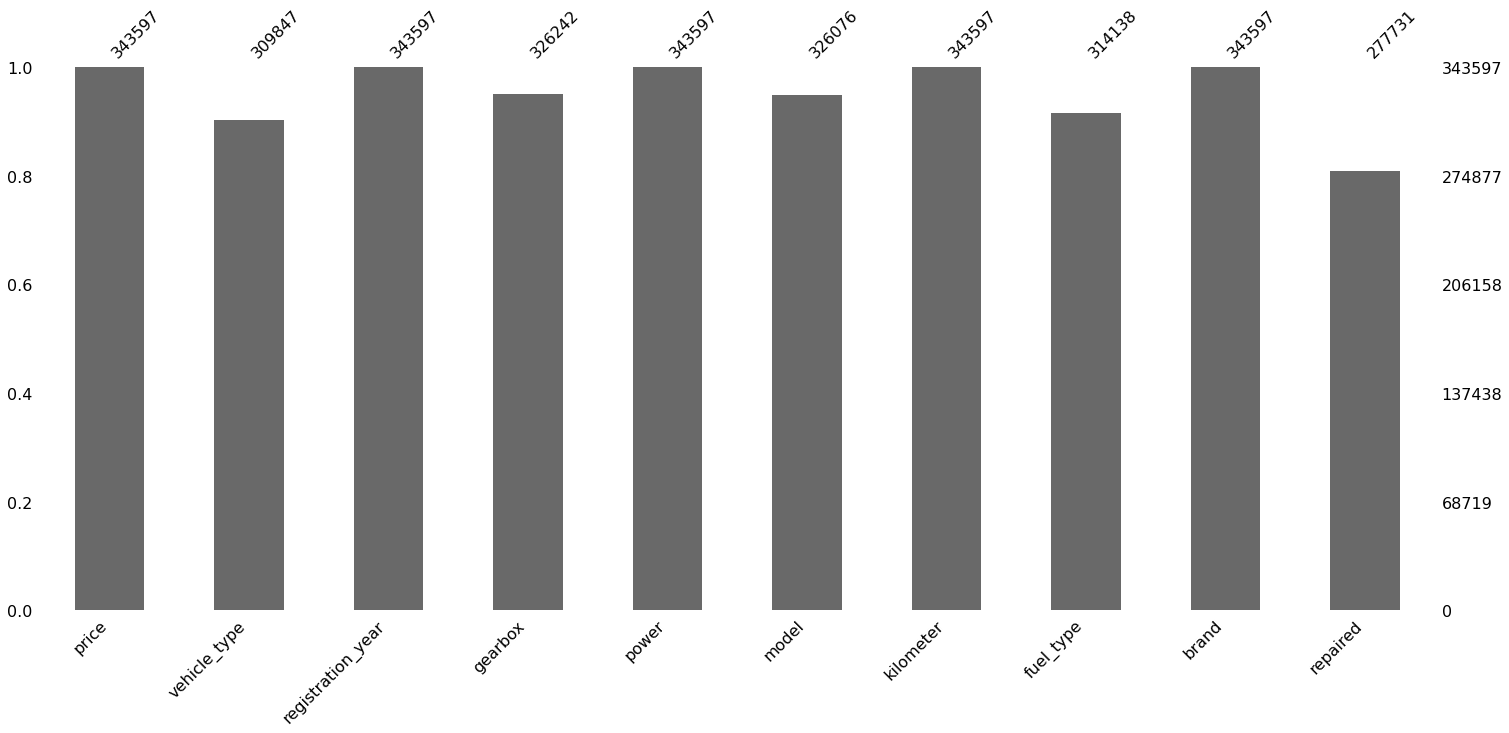

In [17]:
msno.bar(df)

Мы видим пропущенные значения в столбцах:
- vehicle_type
- gearbox
- model
- fuel_type
- repaired 

В столбце "repaired" больше всего пропущенных значений. \
Т.к. это может означать, что машина не ремонтировалась или владелец решил скрыть данные подробности - заменим пропуски на - "no".

In [18]:
df['repaired'] = df['repaired'].fillna('no')

print('Количество пропусков в столбце "repaired" =', df['repaired'].isna().sum())

Количество пропусков в столбце "repaired" = 0


Остальные признаки восстановить невозможно, заполним их модой по группе:

In [19]:
df['model'] = df.groupby(['brand', 'registration_year'])['model'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))

df['vehicle_type'] = df.groupby(['registration_year', 'model'])['vehicle_type'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))

df['gearbox'] = df.groupby(['registration_year', 'model'])['gearbox'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))

df['fuel_type'] = df.groupby(['registration_year', 'model'])['fuel_type'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))





In [20]:
print(df['model'][df['model'] == 'unknown'].count())
print(df['vehicle_type'][df['vehicle_type'] == 'unknown'].count())
print(df['gearbox'][df['gearbox'] == 'unknown'].count())
print(df['fuel_type'][df['fuel_type'] == 'unknown'].count())

2901
12914
248
326


Осталось небольшое количество "неизвестных" значений, удалим их:

In [21]:
df = df.loc[(df['model'] != 'unknown') 
            & (df['vehicle_type'] != 'unknown') 
            & (df['gearbox'] != 'unknown') 
            & (df['fuel_type'] != 'unknown')] 

Количество пропусков в столбце "model" = 0
Количество пропусков в столбце "vehicle_type" = 0
Количество пропусков в столбце "gearbox" = 0
Количество пропусков в столбце "fuel_type" = 0


<AxesSubplot:>

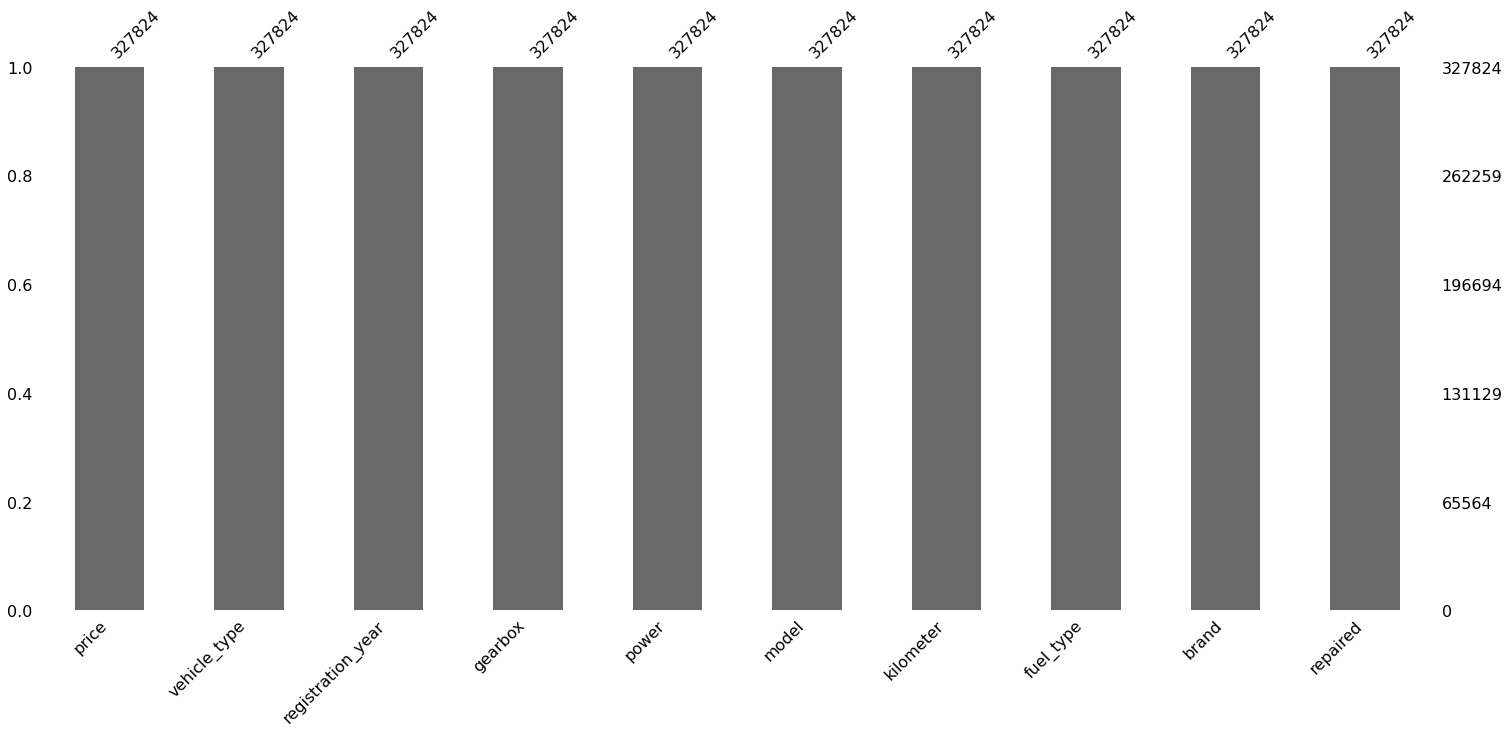

In [22]:
print('Количество пропусков в столбце "model" =', df['model'].isna().sum())
print('Количество пропусков в столбце "vehicle_type" =', df['vehicle_type'].isna().sum())
print('Количество пропусков в столбце "gearbox" =', df['gearbox'].isna().sum())
print('Количество пропусков в столбце "fuel_type" =', df['fuel_type'].isna().sum())
msno.bar(df)

**1.9 Посмотрим выбросы.**

Графический анализ:

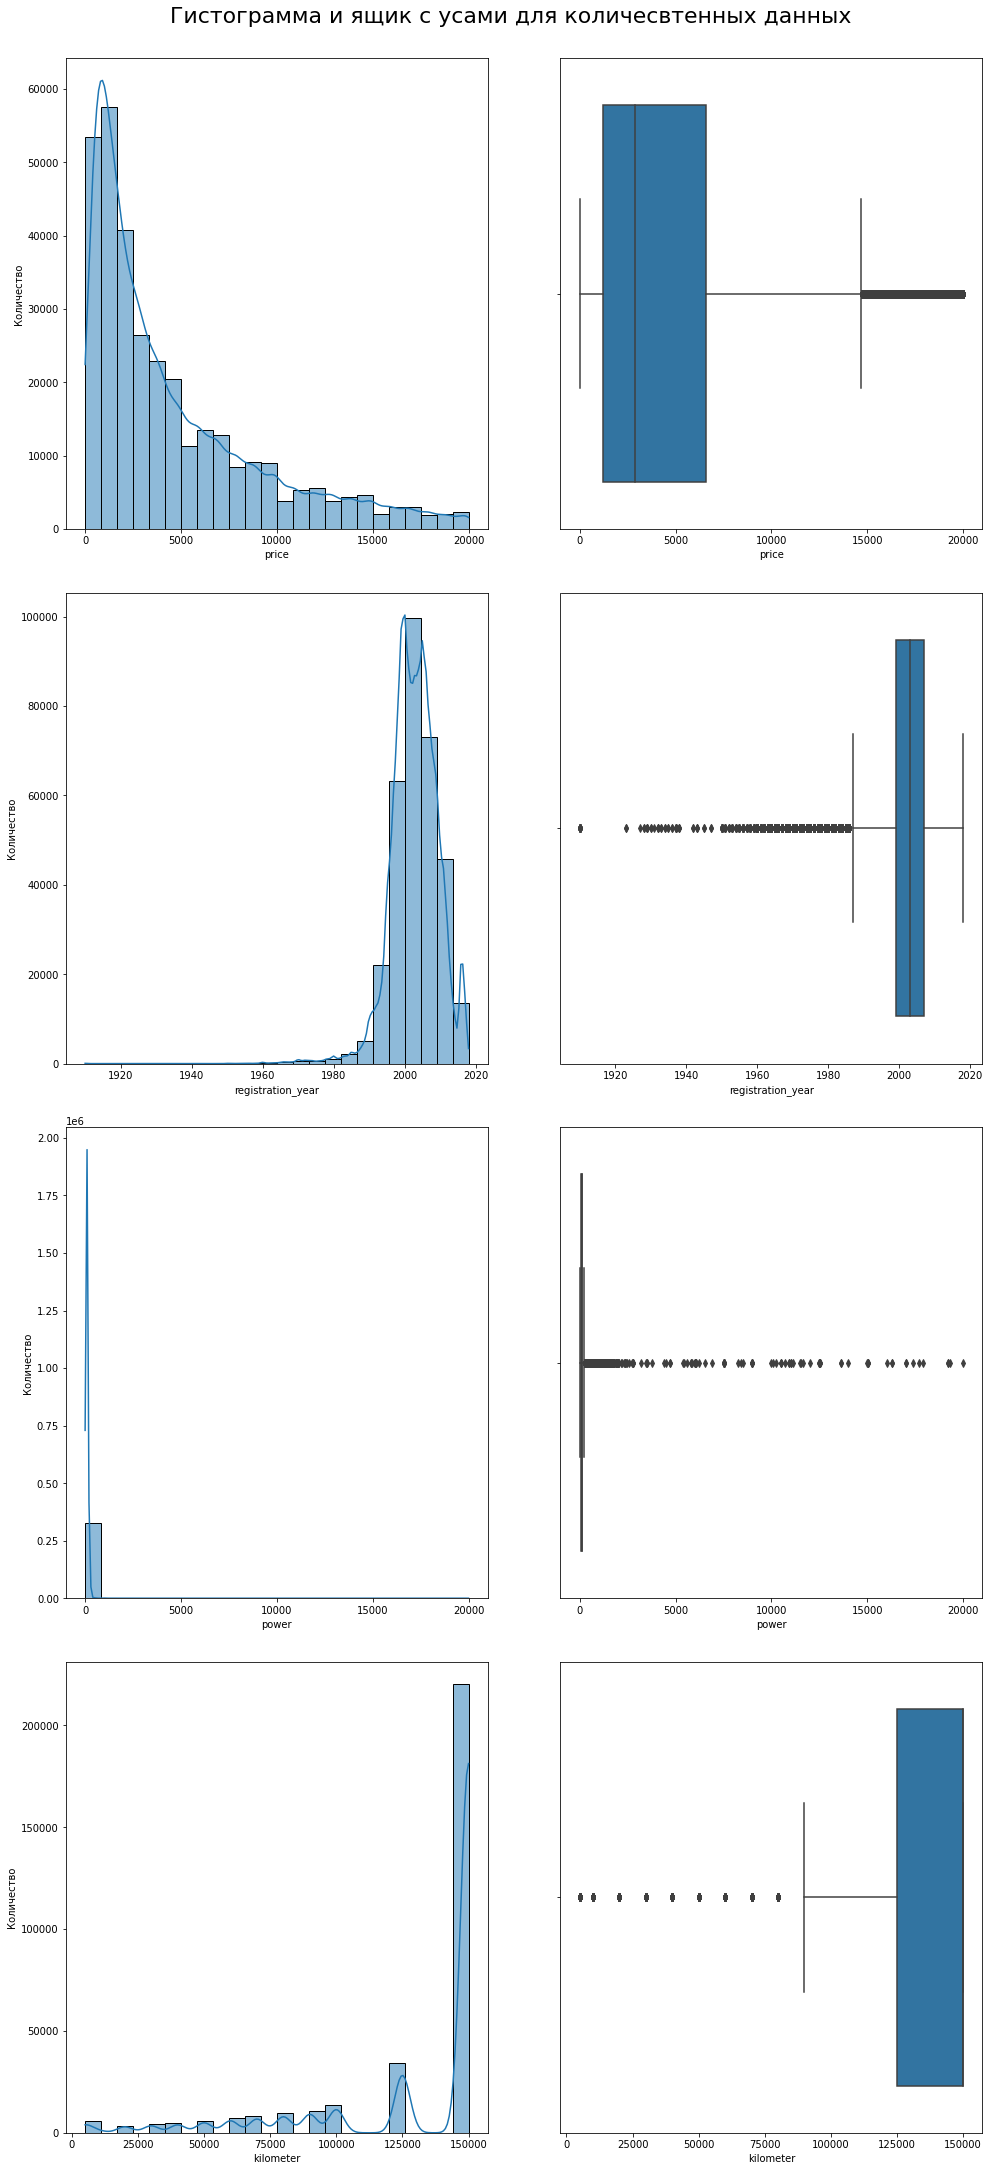

In [23]:
plot_hist(df, df.select_dtypes(exclude=[object]).columns)

Т.к. дата создания последней анкеты: 
- 2016-04-07, 

то в столбце 'registration_year' удалим машины старше 2016 года. \
Также, удалим раритетное авто (после 50 лет эксплуатации) - до 1970 года.

In [24]:
df = df.query('registration_year >= 1970 and registration_year <= 2016')

Рассмотрим подробнее столбец 'power':

In [25]:
df['power'].value_counts()

0        30701
75       21856
60       14646
150      13617
101      12275
         ...  
416          1
317          1
6045         1
671          1
17019        1
Name: power, Length: 671, dtype: int64

Удалим автомобили мощностью более 500 л.с.:

In [26]:
df = df.query('power <= 500')

Нулевые значения заменим медианой по модели автомобиля:

In [27]:
df['power'] = df['power'].replace(0, np.NaN)
median_table = df.groupby('model')['power'].transform('median')
df['power'] = df['power'].fillna(median_table)

Т.к. минимально возможное количество л.с. = 9, посмотрим сколько у нас таких значений:

In [28]:
print(df['power'][df['power'] < 9].count())

62


Удалим:

In [29]:
df = df.query('power >= 9')

По остальным столбцам всё нормально, оставим как есть.

Проверим на мультиколлинеарность:

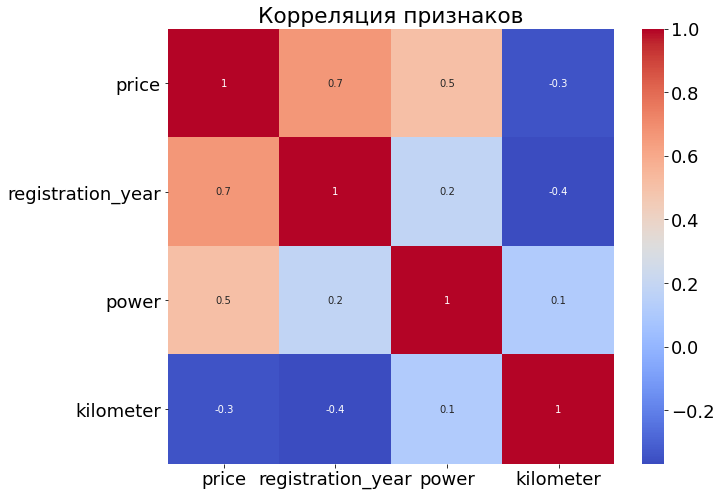

In [30]:
plt.figure(figsize=(10, 8))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
plt.show()

Есть зависимость цены от года регистрации авто и мощности , но она умеренная.

**Вывод:**
- в нашей таблице 16 столбцов и 354368 строк; 
- 30% строк содержит пропуски;
- выявлены дубликаты;
- название столбцов в "верблюжьем стиле";
- есть аномальные значения.


**Проведена предобработка данных:** 
- полных дубликатов не наблюдается, есть совпадающие признаки, оставили всё как есть;

Удалены не информативные признаки: 
- DateCrawled - дата скачивания анкеты из базы;
- DateCreated - дата создания анкеты;
- LastSeen - дата последней активности пользователя
- PostalCode - почтовый индекс владельца анкеты (пользователя);
- NumberOfPictures - количество фотографий автомобиля;
- RegistrationMonth - месяц регистрации автомобиля.


- названия столбцов приведены к змеиному регистру;
- обработаны пропущенные значения;
- обработаны аномальные значения.

## Обучение моделей

Задача:
-	Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. \
Для каждой модели попробуйте разные гиперпараметры.
-	Для оценки качества моделей применяйте метрику RMSE.
-	Значение метрики RMSE должно быть меньше 2500.


In [31]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


Сформируем колличественные и категориальные факторы, целевая:

In [32]:
numeric_var = ['registration_year', 'power', 'kilometer']
category_var = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
targ = ['price']

Формируем фичи и целевую:

In [33]:
feature = df[numeric_var + category_var]
target = df[targ]

Разобьём на обучающую и тестовую выборки:

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    feature, target, shuffle=True, test_size=0.25, stratify=None, random_state=RANDOM_STATE)

In [35]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((242133, 9), (242133, 1), (80712, 9), (80712, 1))

In [36]:
x_train.head(3)

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
316420,2012,156.0,60000,suv,manual,other,petrol,jeep,no
124186,2003,140.0,150000,suv,manual,x_trail,lpg,nissan,no
252978,2007,163.0,150000,wagon,auto,5er,gasoline,bmw,no


**2.1 Категоризация.** 

Определим кодировщик:

In [37]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int')
ohe.fit(x_train[category_var])

# Функция для ohe_категоризации необходимых столбцов и последующего объединения с количественными столбцами

def get_ohe(train, categ):
    
    temp_df = pd.DataFrame(data=ohe.transform(train[categ]), columns=ohe.get_feature_names())
    data = pd.concat([train.reset_index(drop = True), temp_df], axis=1)
    data = data.drop(columns = categ, axis = 1)
    return data

Категоризация:

In [38]:
x_train_cat = get_ohe(x_train, category_var)
x_test_cat = get_ohe(x_test, category_var)

In [39]:
display(x_train_cat.head(2))
x_train_cat.shape

,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
0,2012,156.0,60000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2003,140.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


(242133, 310)

In [40]:
display(x_test_cat.head(2))
x_test_cat.shape

,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
0,2007,150.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2000,60.0,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


(80712, 310)

Применим OrdinalEncoder для RandomForestRegressor:

In [41]:
encoder = OrdinalEncoder()

x_train_oe = x_train[category_var]
x_train_oe = pd.DataFrame(encoder.fit_transform(x_train),
                                 columns=x_train.columns,
                                 index=x_train.index)

x_test_oe = x_test[category_var]
x_test_oe = pd.DataFrame(encoder.fit_transform(x_test),
                                columns=x_test.columns,
                                index=x_test.index)

In [42]:
display(x_train_oe.head(2))
x_train_oe.shape

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
316420,42.0,148.0,6.0,6.0,1.0,166.0,6.0,14.0,0.0
124186,33.0,131.0,12.0,6.0,1.0,241.0,4.0,23.0,0.0


(242133, 9)

In [43]:
display(x_test_oe.head(2))
x_test_oe.shape

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
189905,37.0,141.0,12.0,6.0,0.0,179.0,2.0,23.0,0.0
287964,30.0,48.0,12.0,5.0,1.0,172.0,6.0,37.0,0.0


(80712, 9)

**2.2 Масштабирование.**

Масштабирование для модели линейной регрессии:

In [44]:
scaler = StandardScaler()
scaler.fit(x_train_cat[numeric_var])
x_train_cat[numeric_var] = scaler.transform(x_train_cat[numeric_var]) 
x_test_cat[numeric_var] = scaler.transform(x_test_cat[numeric_var]) 

x_train_cat.head(3)

,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
0,1.497918,0.706855,-1.858197,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.053292,0.399666,0.577630,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.695348,0.841250,0.577630,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**2.3 Моделирование.** \
    **2.3.1 _Линейная регрессия._**

In [45]:
%%time

model_lr = LinearRegression() 
model_lr.fit(x_train_cat, y_train) 


CPU times: user 18.3 s, sys: 6.28 s, total: 24.5 s
Wall time: 24.6 s


LinearRegression()

In [46]:
%%time

predictions = model_lr.predict(x_train_cat) 

CPU times: user 339 ms, sys: 217 ms, total: 556 ms
Wall time: 586 ms


In [47]:
rmse = mean_squared_error(y_train, predictions) ** 0.5 

print('Значение метрики RMSE для линейной регрессии:', round(rmse))

Значение метрики RMSE для линейной регрессии: 2598


Модель обучается быстро, но значение метрики RMSE превышает 2500.

**2.3.2 _Случайный лес._**

In [48]:
# Обозначим модель

model_rfr = RandomForestRegressor(random_state = RANDOM_STATE)

# Зададим параметры
param_grid_rfr = {'n_estimators': np.arange(10,100,10),
      'max_depth': [None,3,5,10],
      'min_samples_split': np.arange(2,20,2),
      'min_samples_leaf' : np.arange(1,20,2),
      'max_samples' : [100]
  }

In [49]:
start_rfr = time.time()

# Подберем гиперпараметры
grid_rfr = RandomizedSearchCV(
    model_rfr, param_grid_rfr, scoring='neg_root_mean_squared_error', cv=5, 
    random_state=RANDOM_STATE)

# Обучим модель  
model_rfr = grid_rfr.fit(x_train_oe, y_train)

end_rfr = time.time()

In [50]:
print(f'Лучшие параметры для случайного леса: ', model_rfr.best_params_)
print(f'Значение метрики RMSE для лучших параметров случайного леса: %.4f' % -model_rfr.best_score_)
print(f'Время леса равно: %.4f', round((end_rfr-start_rfr)/60, 3), ' минут')

Лучшие параметры для случайного леса:  {'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_samples': 100, 'max_depth': 10}
Значение метрики RMSE для лучших параметров случайного леса: 2611.1926
Время леса равно: %.4f 0.172  минут


In [51]:
# Время обучения и предсказания

time_train_rfr = model_rfr.cv_results_['mean_fit_time'].mean()
time_pred_rfr = model_rfr.cv_results_['mean_score_time'].mean()

Модель обучается быстро, но значение метрики RMSE превышает 2500.

**2.3.3 _LightGBM._**

In [52]:
# Для LightGBM дополнительно обработаем категориальные признаки

for i in category_var:
    x_train[i] = pd.Series(x_train[i], dtype='category')
    x_test[i] = pd.Series(x_test[i], dtype='category')


In [53]:
# Обозначим модель

model_lgbm = LGBMRegressor(boosting_type='gbdt',
                           verbose=0,
                           seed=RANDOM_STATE)

# Зададим параметры
param_grid_lgbm = {'learning_rate': np.logspace(-3, 0, 5),
                   'n_estimators': range(20, 61, 20),
                   'num_leaves': range(20, 41, 10),
                   'force_col_wise': [True]}

In [54]:
start_lgbm = time.time()

# Подберем гиперпараметры
grid_lgbm = RandomizedSearchCV(
    model_lgbm, param_grid_lgbm, scoring='neg_root_mean_squared_error', cv=5)

# Обучим модель  
model_lgbm = grid_lgbm.fit(x_train, y_train)

end_lgbm = time.time()

In [55]:
print(f'Лучшие параметры для LightGBM: ', model_lgbm.best_params_)
print(f'Значение метрики RMSE для лучших параметров LightGBM : %.4f' % -model_lgbm.best_score_)
print(f'Время LightGBM равно: %.4f', round((end_lgbm-start_lgbm)/60, 3), ' минут')

Лучшие параметры для LightGBM:  {'num_leaves': 20, 'n_estimators': 40, 'learning_rate': 0.1778279410038923, 'force_col_wise': True}
Значение метрики RMSE для лучших параметров LightGBM : 1704.1964
Время LightGBM равно: %.4f 2.702  минут


In [56]:
# Время обучения и предсказания

time_train_lgbm = model_lgbm.cv_results_['mean_fit_time'].mean()
time_pred_lgbm = model_lgbm.cv_results_['mean_score_time'].mean()

Модель обучается достаточно быстро и значение метрики RMSE не превышает 2500.

**2.3.4 _CatBoost._**

In [57]:
# Обозначим модель

model_cb = CatBoostRegressor(loss_function='RMSE',
                             cat_features=category_var,
                             verbose=0,
                             random_seed=RANDOM_STATE)

# Зададим параметры
param_grid_cb = {'learning_rate': np.logspace(-3, 0, 5),
                 'n_estimators' : range (50,100),
                 'max_depth' : range(5, 7, 10)}

In [58]:
start_cb = time.time()

# Подберем гиперпараметры
grid_cb = RandomizedSearchCV(
    model_cb, param_grid_cb, scoring='neg_root_mean_squared_error', cv=5, 
    random_state=RANDOM_STATE)

# Обучим модель  
model_cb = grid_cb.fit(x_train, y_train)

end_cb = time.time()

In [59]:
print(f'Лучшие параметры для CatBoost: ', model_cb.best_params_)
print(f'Значение метрики RMSE для лучших параметров CatBoost: %.4f' % -model_cb.best_score_)
print(f'Время CatBoost равно: %.4f', round((end_cb-start_cb)/60, 3), ' минут')

Лучшие параметры для CatBoost:  {'n_estimators': 96, 'max_depth': 5, 'learning_rate': 1.0}
Значение метрики RMSE для лучших параметров CatBoost: 1727.9601
Время CatBoost равно: %.4f 4.486  минут


In [60]:
# Время обучения и предсказания

time_train_cb = model_cb.cv_results_['mean_fit_time'].mean()
time_pred_cb = model_cb.cv_results_['mean_score_time'].mean()

Модель обучается достаточно быстро и значение метрики RMSE не превышает 2500.

**Вывод:**

Лучший результат у модели LightGBM:
- параметры для LightGBM:  {'num_leaves': 20, 'n_estimators': 40, 'learning_rate': 0.1778279410038923, 'force_col_wise': True}
- значение метрики RMSE для лучших параметров LightGBM : 1704.1964 

её и будем проверять на тестовой выборке.


## Анализ моделей

**Проанализируем, сравним результаты, выберем лучшую модель и проверим её качество на тестовой выборке.**

In [64]:
results = {
    'Model' : ['LinearRegression', 'RandomForest', 'LightGBM', 'CatBoost'],
    'RMSE' :pd.Series([round(rmse), -model_rfr.best_score_, -model_lgbm.best_score_, -model_cb.best_score_]),
    'Время обучения': pd.Series([0.41, 
                                 time_train_rfr,
                                 time_train_lgbm,
                                 time_train_cb]),
    'Время предсказания': pd.Series([0.0098, 
                                 time_pred_rfr,
                                 time_pred_lgbm,
                                 time_pred_cb])
    }
display(pd.DataFrame(results))

,Model,RMSE,Время обучения,Время предсказания
0,LinearRegression,2598.000000,0.410000,0.009800
1,RandomForest,2611.192551,0.127668,0.076177
2,LightGBM,1704.196409,2.985203,0.196003
3,CatBoost,1727.960109,5.196106,0.034043


In [62]:
start_bestlgbm = time.time()

prediction = model_lgbm.predict(x_test)
result = mean_squared_error(y_test, prediction)** 0.5

end_bestlgbm = time.time()

print(f'Значение метрики RMSE для лучшей модели: %.4f' % result)

Значение метрики RMSE для лучшей модели: 1701.7476


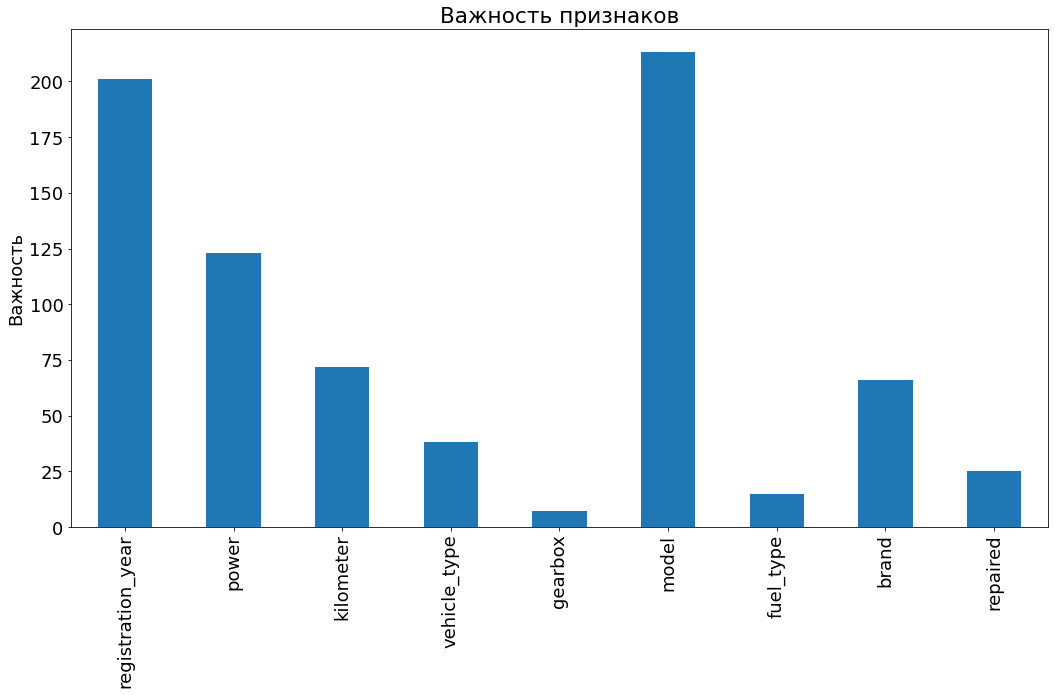

In [63]:
imp = pd.Series(model_lgbm.best_estimator_.feature_importances_,
               x_train.columns)

fig, ax = plt.subplots(figsize=(15,10))
imp.plot.bar(ax=ax)
ax.set_title('Важность признаков')
ax.set_ylabel('Важность')
fig.tight_layout()

Наибольшее влияние на стоимость автомобиля оказывают:
- год выпуска;
- мощность двигателя;
- модель.

**Общий вывод:**
1. **_Были подготовлены данные:_**
- в нашей таблице 16 столбцов и 354368 строк; 
- полных дубликатов не наблюдается, есть совпадающие признаки, оставили всё как есть;

Удалены не информативные признаки: 
- DateCrawled - дата скачивания анкеты из базы;
- DateCreated - дата создания анкеты;
- LastSeen - дата последней активности пользователя
- PostalCode - почтовый индекс владельца анкеты (пользователя);
- NumberOfPictures - количество фотографий автомобиля;
- RegistrationMonth - месяц регистрации автомобиля.


- названия столбцов приведены к змеиному регистру;
- обработаны пропущенные значения;
- обработаны аномальные значения.

2. **_Обучены классические и бустинговые модели:_** 

			
| Model | RMSE | Время обучения | Время предсказания | 
|---|---|-----------|------|
| LinearRegression | 2598 | 0.490000 | 0.003500 | 
| RandomForest | 2611 | 0.127668 | 0.076177 |
| LightGBM | 1704 | 2.985203 | 0.196003 |
| CatBoost | 1727 | 5.196106 | 0.034043 | 

Классические модели показали плохой результат. \
Лучший результат у модели LightGBM:
- Лучшие параметры для LightGBM:  {'num_leaves': 20, 'n_estimators': 40, 'learning_rate': 0.1778279410038923, 'force_col_wise': True}
- Значение метрики RMSE для лучших параметров LightGBM : 1704.1964
- Время LightGBM равно: %.4f 2.702  минут

3. **_Выбрана лучшая модель - LightGBM._** 
- Значение метрики RMSE для лучшей модели: 1701

4. **Наибольшее влияние на стоимость автомобиля оказывают:**
- год выпуска;
- мощность двигателя;
- модель.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей